## Stacked LSTM model on Time Series Data with Pie Chart

### This is the basic prototype implementation for Time series data mentioned in my gsoc_proposal

1 : Hitting endpoints from time_series keys and then merging data on 
    selected features from list of time_series values
    
2 : Testing Bsic stacked LSTM model on three different look_back days
    (number of step model will look back to predict next time stamps)
    
3 : We can see that look_back days = 1 has less mae loss

4 : Plotted the Loss Distributon graph

5 : Plotted the anomaly points with different features/metrics for a better understanding

6 : Created pie chart for a particular anomaly which shows cotribution of 
    every features/metrics for a particular anomaly.

In [175]:
import os
def read_config(section, name=None, environment_variable=None, default=None, config_file_path='../../augur.config.json', no_config_file=0, use_main_config=0):
    """
    Read a variable in specified section of the config file, unless provided an environment variable

    :param section: location of given variable
    :param name: name of variable
    """
    _config_file_name = 'augur.config.json'
    _config_bad = False
    _already_exported = {}
    _runtime_location = 'runtime/'
    _default_config = {}
    _config_file = None

    try:
        _config_file = open(config_file_path, 'r+')
    except:
        print('Couldn\'t open {}'.format(_config_file_name))

    # Load the config file
    try:
        config_text = _config_file.read()
        _config = json.loads(config_text)
    except json.decoder.JSONDecodeError as e:
        if not _config_bad:
            _using_config_file = False
            print('{} could not be parsed, using defaults. Fix that file, or delete it and run this again to regenerate it. Error: {}'.format(config_file_path, str(e)))
        _config = _default_config

    value = None
    if environment_variable is not None:
        value = os.getenv(environment_variable)
    if value is None:
        try:
            if name is not None:
                value = _config[section][name]
            else:
                value = _config[section]
        except Exception as e:
            value = default
            if not section in _config:
                _config[section] = {}

    return value

### Collecting data by Hitting endpoints

In [176]:
time_series = {'closed-issues-count':['date','closed_count'],
               'code-changes':['date','commit_count'],
               'code-changes-lines':['date','added','removed'],
               'issues-active':['date','issues'],
               'issues-closed':['date','issues'],
               'contributors-new':['date','new_contributors'],
               'reviews':['date','pull_requests']}
columns = ['date','closed_issue_count','commit_count','added','removed','issues_active','issues_closed','new_contributors','pull_requests']

import pandas as pd
import requests
import datetime
import json
training_days = 365
repo_id = 25430
augur_api_host = read_config("Server", "host", "AUGUR_HOST", "0.0.0.0",config_file_path='/Users/pratikmishra/augur/augur.config.json')
augur_api_port = read_config("Server", "port", "AUGUR_PORT", 5000,config_file_path='/Users/pratikmishra/augur/augur.config.json')
base_url = 'http://{}:{}/api/unstable/repo-groups/20/repos/{}/'.format(augur_api_host,augur_api_port,repo_id)

def collect_data(category):
    if(category==time_series):
        df = pd.DataFrame(columns=['date'])
        
    for endpoint in category.keys():
    
        url = base_url + endpoint
        print("Hitting endpoint: " + url + "\n")

        data = requests.get(url=url).json()
    
        if len(data) == 0:
            print("Endpoint with url: {} returned an empty response. Moving on to next endpoint.\n".format(url))
            continue
                    
        metric_df = pd.DataFrame.from_records(data)
        metric_df['date'] = pd.to_datetime(metric_df['date']).dt.date
    
        df = pd.DataFrame(pd.merge(df,metric_df.loc[:,category[endpoint]],how = 'outer',on = 'date'))

    return df


time_data = collect_data(time_series)
time_data.columns = columns

Hitting endpoint: http://0.0.0.0:5000/api/unstable/repo-groups/20/repos/25430/closed-issues-count

Hitting endpoint: http://0.0.0.0:5000/api/unstable/repo-groups/20/repos/25430/code-changes

Hitting endpoint: http://0.0.0.0:5000/api/unstable/repo-groups/20/repos/25430/code-changes-lines

Hitting endpoint: http://0.0.0.0:5000/api/unstable/repo-groups/20/repos/25430/issues-active

Hitting endpoint: http://0.0.0.0:5000/api/unstable/repo-groups/20/repos/25430/issues-closed

Hitting endpoint: http://0.0.0.0:5000/api/unstable/repo-groups/20/repos/25430/contributors-new

Hitting endpoint: http://0.0.0.0:5000/api/unstable/repo-groups/20/repos/25430/reviews



In [177]:

# Data is not regular that's why I had taken all the data points otherwise we will initialse df data frame
# with given number of training days with the following method:

#begin_date = datetime.datetime.now().replace(hour=0, minute=0, second=0, microsecond=0) - datetime.timedelta(days=training_days)
#begin_date = begin_date.strftime('%Y-%m-%d')
#index = pd.date_range(begin_date, periods=training_days, freq='D')
#df = df.reset_index()
#df.columns = ['date']
#df['date'] = pd.to_datetime(df['date']).dt.date
#df.date.astype(str)

#this will merge metric_df with previous 365 daya

In [178]:
time_data = time_data.sort_values(by='date')
time_data = time_data.set_index('date')
#time_data.reset_index(inplace=True,drop=True)
time_data = time_data.fillna(0)

time_data.head()

,closed_issue_count,commit_count,added,removed,issues_active,issues_closed,new_contributors,pull_requests
date,,,,,,,,
2017-01-04,0.0,1.0,18.0,2.0,0.0,0.0,0.0,0.0
2017-01-09,0.0,5.0,646.0,551.0,0.0,0.0,0.0,0.0
2017-01-10,0.0,1.0,59.0,23.0,0.0,0.0,0.0,0.0
2017-01-11,0.0,1.0,85.0,24.0,0.0,0.0,0.0,0.0
2017-01-16,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Scale Data

In [179]:
# make another copy of data and then scale it.
from sklearn.preprocessing import MinMaxScaler
df = time_data.copy()
scaler = MinMaxScaler()
df = pd.DataFrame(scaler.fit_transform(df))
df.columns = ['closed_issue_count','commit_count','added','removed','issues_active','issues_closed','new_contributors','pull_requests']
df.describe()

,closed_issue_count,commit_count,added,removed,issues_active,issues_closed,new_contributors,pull_requests
count,647.000000,647.000000,647.000000,647.000000,647.000000,647.000000,647.000000,647.000000
mean,0.023897,0.125460,0.012958,0.010431,0.036698,0.034518,0.035549,0.035549
std,0.084556,0.165826,0.065266,0.062363,0.089495,0.104422,0.142850,0.087079
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.017241,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.068966,0.000309,0.000081,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.172414,0.002218,0.001005,0.038462,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [180]:
time_data.columns

Index(['closed_issue_count', 'commit_count', 'added', 'removed',
       'issues_active', 'issues_closed', 'new_contributors', 'pull_requests'],
      dtype='object')

In [181]:
df.index = time_data.index
df.head()

,closed_issue_count,commit_count,added,removed,issues_active,issues_closed,new_contributors,pull_requests
date,,,,,,,,
2017-01-04,0.000000,0.034483,0.000071,0.000006,0.0,0.0,0.0,0.0
2017-01-09,0.000000,0.172414,0.002557,0.001716,0.0,0.0,0.0,0.0
2017-01-10,0.000000,0.034483,0.000234,0.000072,0.0,0.0,0.0,0.0
2017-01-11,0.000000,0.034483,0.000336,0.000075,0.0,0.0,0.0,0.0
2017-01-16,0.230769,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0


### Implementing Stacked LSTM with Dense layer for multiple output

#### Plotting mae_loss with three look_back days

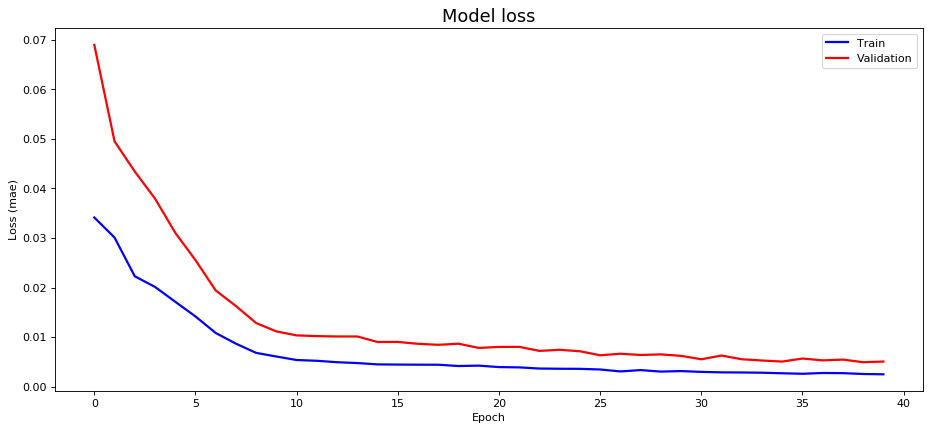

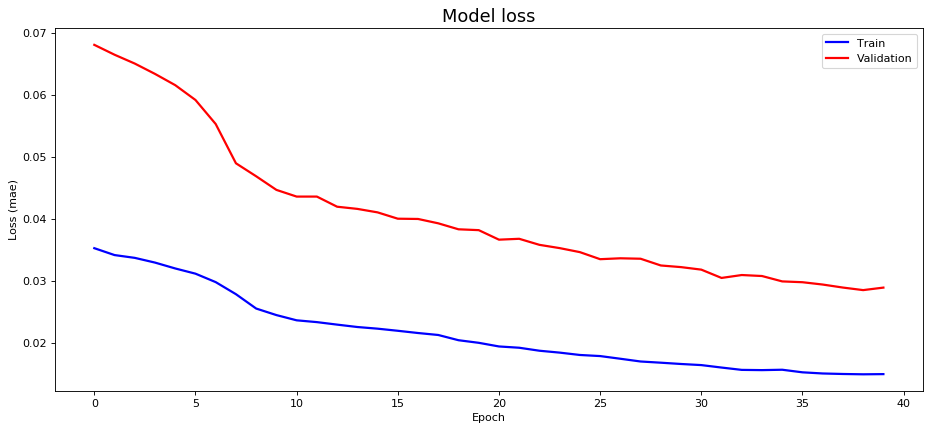

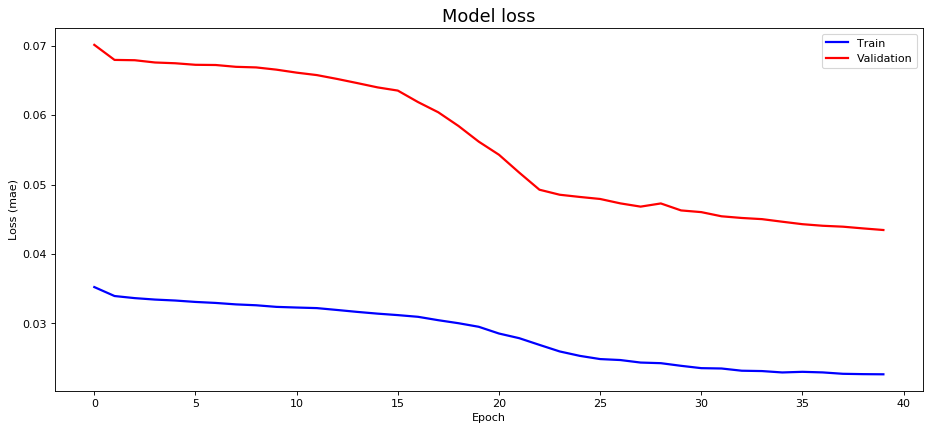

In [182]:
#implement Stakced LSTM model with additional dense layer to predict every columns
import numpy as np
from numpy import array
import matplotlib.pyplot as plt
from numpy import hstack
import seaborn as sns
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
%matplotlib inline
look_back_days = [1,3,7]  #number of datapoints it will look back to predict next data point


def lstm_model(data,days):
    
    model = Sequential()
    model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(days, data.shape[1])))
    model.add(LSTM(52, activation='relu',return_sequences=True))
    model.add(Dense(data.values.shape[1]))
    model.compile(optimizer='adam', loss='mae')
    return model
    



nb_epochs = 40
batch_size = 5
for days in look_back_days:
    data = df.iloc[0:(int(df.shape[0]/days)*days)]
    X_train = data.values.reshape(int(data.values.shape[0]/days),days, data.shape[1])
    
    model_value = lstm_model(data,days).fit(X_train, X_train, epochs=nb_epochs, batch_size=batch_size,
                    validation_split=0.08,verbose=0).history
    
    fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
    ax.plot(model_value['loss'], 'b', label='Train', linewidth=2)
    ax.plot(model_value['val_loss'], 'r', label='Validation', linewidth=2)
    ax.set_title('Model loss', fontsize=16)
    ax.set_ylabel('Loss (mae)')
    ax.set_xlabel('Epoch')
    ax.legend(loc='upper right')
    plt.show()

/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


(0.0, 0.01)

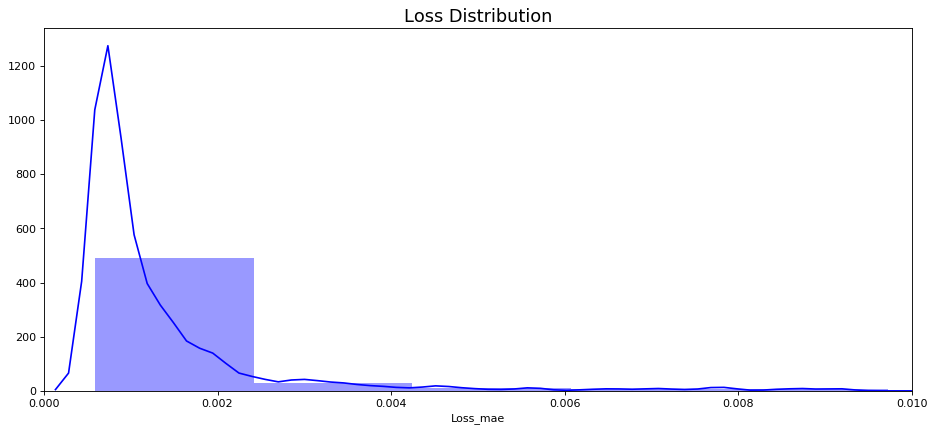

In [183]:
# We can see that when look_back_days is equal to 1 then model have less erros between train and validation
#and it performs better
# so we will select look_back_days = 1
from keras.models import load_model
days = 1
nb_epochs = 50

batch_size = 5

data = df.iloc[0:(int(df.shape[0]/days)*days)]

X_train = data.values.reshape(int(data.values.shape[0]/days),days, data.shape[1])
model = lstm_model(data,days)
model.fit(X_train,X_train,epochs=nb_epochs, batch_size=batch_size,
                    validation_split=0.08,verbose=0)
#model = load_model('my_model.h5')
X_predict = model.predict(X_train)
X_predict = X_predict.reshape(X_predict.shape[0]*days, X_predict.shape[2])
X_predict = pd.DataFrame(X_predict, columns=df.columns)
X_predict.index = df.index

mae_score = pd.DataFrame(index=df.index)
Xtrain = X_train.reshape(X_train.shape[0]*days, X_train.shape[2])
mae_score['Loss_mae'] = np.mean(np.abs(X_predict-Xtrain), axis = 1)
plt.figure(figsize=(14,6), dpi=80)
plt.title('Loss Distribution', fontsize=16)
sns.distplot(mae_score['Loss_mae'], bins = 10, kde= True, color = 'blue');
plt.xlim([0.0,.01])

### Selecting Threshold value and plotting loss_mae 

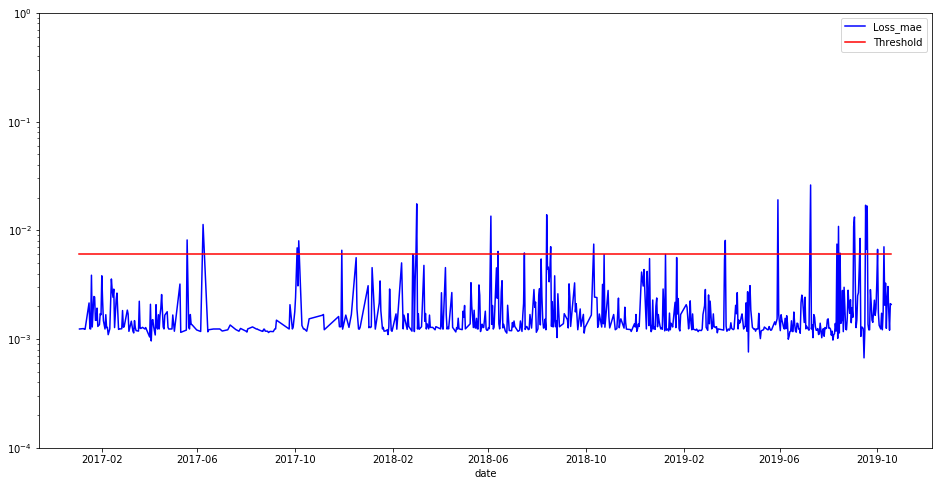

In [184]:


score_train = pd.DataFrame(index=df.index)
score_train['Loss_mae'] = np.mean(np.abs(X_pred-Xtrain), axis = 1)
score_train['Threshold'] = 0.006
score_train['Anomaly'] = score_train['Loss_mae'] > score_train['Threshold']
    
score_train.plot(logy=True,  figsize=(16,8), ylim=[1e-4,1e0], color=['blue','red'])
    

In [185]:
score_train.Anomaly.value_counts()

False    619
True      28
Name: Anomaly, dtype: int64

### Plotting normal data with every features/metrics and Anomaly points

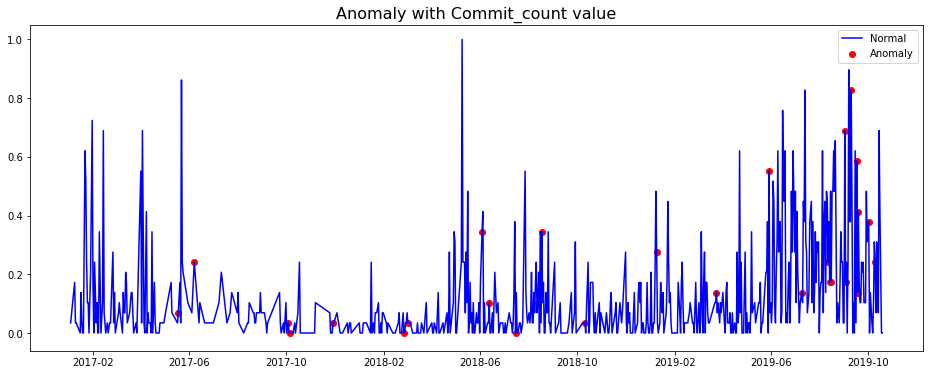

In [186]:
pd.plotting.register_matplotlib_converters()
fig, ax = plt.subplots(figsize=(16,6))
anomaly = df.loc[score_train['Anomaly'] == True, df.columns] #anomaly

ax.plot(df.index, df['commit_count'], color='blue', label = 'Normal')#anomaly points with "added" values
ax.scatter(anomaly.index,anomaly['commit_count'], color='red', label = 'Anomaly')
plt.title('Anomaly with Commit_count value', fontsize=16)
plt.legend()
plt.show();

In [187]:
anomaly.head()

,closed_issue_count,commit_count,added,removed,issues_active,issues_closed,new_contributors,pull_requests
date,,,,,,,,
2017-05-19,0.0,0.068966,0.504591,0.000069,0.0,0.0,0.0,0.0
2017-06-08,0.0,0.241379,0.169159,0.458581,0.0,0.0,0.0,0.0
2017-10-04,0.0,0.034483,0.376369,0.000128,0.0,0.0,0.0,0.0
2017-10-06,0.0,0.000000,0.000000,0.000000,1.0,0.0,0.0,0.0
2017-11-29,0.0,0.034483,0.020953,0.186370,0.0,0.0,0.0,0.0


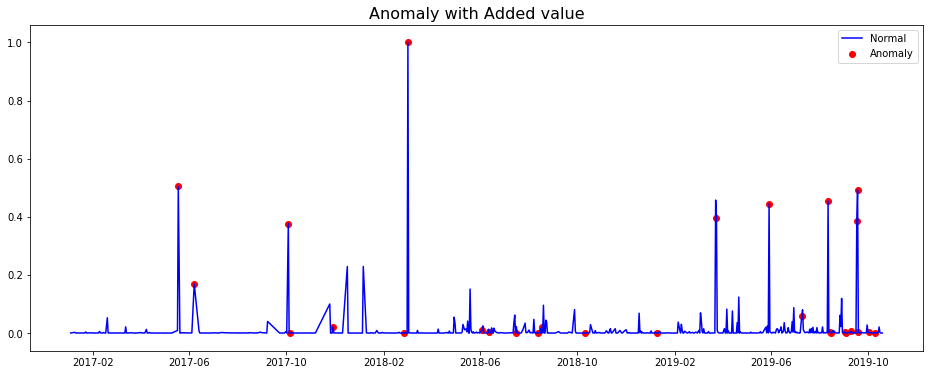

In [188]:
fig, ax = plt.subplots(figsize=(16,6))

ax.plot(df.index, df['added'], color='blue', label = 'Normal')#anomaly points with "added" values
ax.scatter(anomaly.index,anomaly['added'], color='red', label = 'Anomaly')
plt.title('Anomaly with Added value', fontsize=16)
plt.legend()
plt.show();

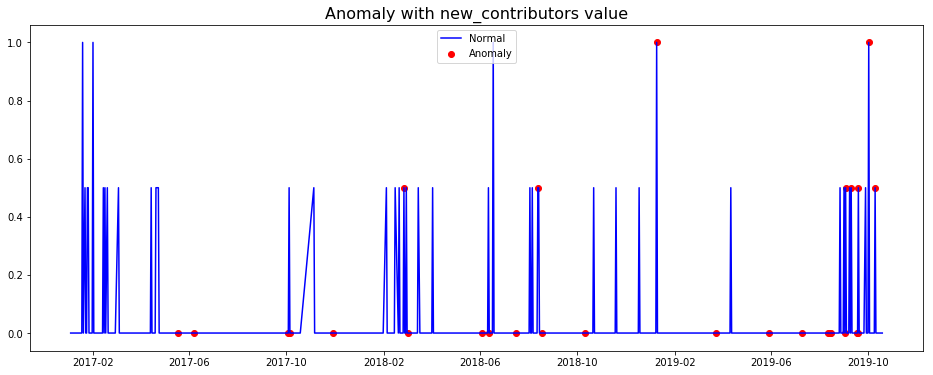

In [189]:
fig, ax = plt.subplots(figsize=(16,6))

ax.plot(df.index, df['new_contributors'], color='blue', label = 'Normal')#anomaly points with "added" values
ax.scatter(anomaly.index,anomaly['new_contributors'], color='red', label = 'Anomaly')
plt.title('Anomaly with new_contributors value', fontsize=16)
plt.legend()
plt.show();

### Creating DataFrame with fraction_error for every features/metrics

In [190]:
df_error = pd.DataFrame(np.abs(df-X_predict))
df_error.columns = df.columns
df_error.head()

,closed_issue_count,commit_count,added,removed,issues_active,issues_closed,new_contributors,pull_requests
date,,,,,,,,
2017-01-04,0.000096,0.000005,0.000510,0.000351,0.001627,0.001394,0.000347,0.000429
2017-01-09,0.000155,0.000576,0.000764,0.000820,0.001550,0.001870,0.000351,0.000717
2017-01-10,0.000094,0.000001,0.000514,0.000370,0.001629,0.001390,0.000345,0.000430
2017-01-11,0.000094,0.000004,0.000518,0.000366,0.001631,0.001389,0.000345,0.000431
2017-01-16,0.000104,0.000606,0.000070,0.000316,0.001530,0.002652,0.000986,0.001467


In [191]:
df_anomaly_error = df_error.loc[scored_train['Anomaly'] == True, df_error.columns]

df_fraction_error = pd.DataFrame()
for i in df_error.columns:
    df_fraction_error[i]=(df_anomaly_error[i])/(df_anomaly_error[list(df_error.columns)].sum(axis=1))

In [192]:
df_fraction_error.head()

,closed_issue_count,commit_count,added,removed,issues_active,issues_closed,new_contributors,pull_requests
date,,,,,,,,
2017-05-19,0.048220,0.015996,0.478837,0.081576,0.075907,0.067811,0.081804,0.149850
2017-06-08,0.101849,0.001926,0.193089,0.350967,0.197750,0.008681,0.055218,0.090520
2017-10-04,0.023358,0.051520,0.459571,0.137006,0.124634,0.041703,0.114429,0.047779
2017-10-06,0.058203,0.138242,0.063657,0.016002,0.364075,0.100581,0.129641,0.129598
2017-11-29,0.007269,0.044701,0.049624,0.591208,0.222174,0.036494,0.017161,0.031370


### Implementing Pie Chart

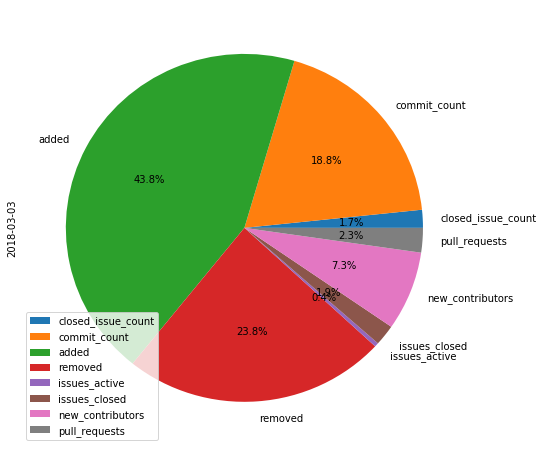

In [193]:
fig, ax = plt.subplots(1,1)
fig.set_size_inches(8,8)
df_fraction_error.iloc[10].plot(kind='pie',ax=ax,autopct='%1.1f%%' )
plt.legend(loc = 'lower left')
#ax.set_ylabel()
#ax.set_xlabel()


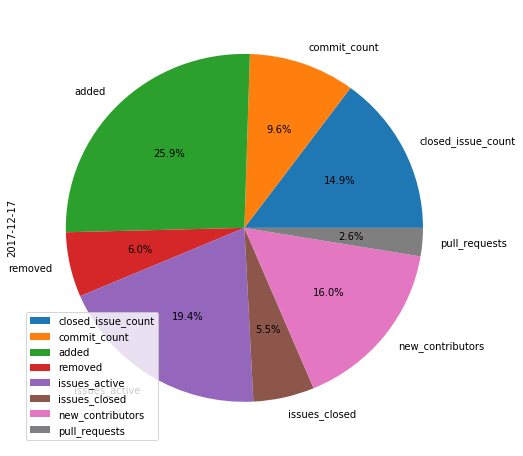

In [194]:
fig, ax = plt.subplots(1,1)
fig.set_size_inches(8,8)
df_fraction_error.iloc[5].plot(kind='pie',ax=ax,autopct='%1.1f%%' )
plt.legend(loc = 'lower left')
#ax.set_ylabel()
#ax.set_xlabel()

In [195]:
X_predict.describe()

,closed_issue_count,commit_count,added,removed,issues_active,issues_closed,new_contributors,pull_requests
count,647.000000,647.000000,647.000000,647.000000,647.000000,647.000000,647.000000,647.000000
mean,0.023977,0.125390,0.012198,0.009779,0.034985,0.032704,0.035017,0.035577
std,0.084788,0.165846,0.066042,0.062546,0.090058,0.104392,0.143095,0.086979
min,-0.011629,-0.003741,-0.009529,-0.035305,-0.024535,-0.008222,-0.014079,-0.018558
25%,-0.000135,0.019657,-0.000485,-0.000314,-0.001678,-0.001983,-0.000627,-0.000072
50%,0.000093,0.068693,-0.000073,0.000011,-0.001188,-0.001529,-0.000311,0.000497
75%,0.000368,0.171807,0.001749,0.001322,0.036313,-0.001279,-0.000114,0.002138
max,1.015287,1.012092,1.065986,1.038849,1.022354,1.011191,1.035979,1.009138


In [196]:
df.describe()

,closed_issue_count,commit_count,added,removed,issues_active,issues_closed,new_contributors,pull_requests
count,647.000000,647.000000,647.000000,647.000000,647.000000,647.000000,647.000000,647.000000
mean,0.023897,0.125460,0.012958,0.010431,0.036698,0.034518,0.035549,0.035549
std,0.084556,0.165826,0.065266,0.062363,0.089495,0.104422,0.142850,0.087079
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.017241,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.068966,0.000309,0.000081,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.172414,0.002218,0.001005,0.038462,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Basic LSTM model used in this notebook however different models can be made and selected